# Marginal Costs

Gets marginal cost values from base network (no-dr) to use as a scenario dimension

In [55]:
import matplotlib.pyplot as plt
import pypsa
from matplotlib.lines import Line2D
from pathlib import Path

In [56]:
SCENARIO = "lgas"
REGION = "caiso"
if REGION == "caiso":
    CLUSTERS = "4"
    SIMPLE = "80"
else:
    CLUSTERS = "6"
    SIMPLE = "120"
NETWORK = Path("..", "data", REGION, "networks", SCENARIO, "networks", f"elec_s{SIMPLE}_c{CLUSTERS}m_ec_lv1.0_1h-TCT_E-G.nc")
FIGURES = Path("..","figures","marginal_costs")

In [57]:
n = pypsa.Network(NETWORK)

INFO:pypsa.io:Imported network elec_s80_c4m_ec_lv1.0_1h-TCT_E-G.nc has buses, carriers, generators, global_constraints, links, loads, storage_units, stores


In [58]:
FONTSIZE = 14

CARRIERS = {
    "res-total-elec": "Electricity",
    "res-total-space-heat": "Space Heat",
    # "res-total-water-heat": "Water Heat",
    "res-total-cool": "Space Cool",
    "com-total-elec": "Electricity",
    "com-total-space-heat": "Space Heat",
    # "com-total-water-heat": "Water Heat",
    "com-total-cool": "Space Cool",
    "ind-elec": "Electricity",
    "ind-heat": "Heat",
    "trn-lpg-veh": "LPG",
    "trn-elec-veh": "Electricity",
}

COLORS = {
    "Electricity": "tab:olive",
    "Space Heat": "tab:red",
    "Water Heat": "tab:purple",
    "Space Cool": "tab:blue",
    "Heat": "tab:red",
    "LPG": "tab:blue",
}

SECTORS = {"res":"Residential", "com":"Commercial", "ind":"Industrial", "trn":"Transportation"}

FIGSIZE = (12, 5)

In [59]:
def get_marginal_costs(n: pypsa.Network, sector: str, clip: tuple[float, float] = (0, 500)):
    cars = [x for x in CARRIERS if x.startswith(sector)]
    buses = n.buses[n.buses.carrier.isin(cars)].index.to_list()
    buses_t = n.buses_t.marginal_price[buses]
    bus_carrier_mapper = n.buses.carrier.to_dict()
    buses_t = buses_t.rename(columns=bus_carrier_mapper).rename(columns=CARRIERS)
    buses_t = buses_t.T.groupby(level=0).mean().T
    return buses_t.clip(lower=clip[0], upper=clip[1])

In [60]:
def plot_marginal_costs(
    n: pypsa.Network,
    sector: str,
    resample: str = "1D",
    average: str | None = None,
    clip: tuple[float, float] = (0, 250),
    save: str | None = None,
    **kwargs,
):
    df = get_marginal_costs(n, sector, clip)
    df = df.droplevel(0)  # period
    df = df.resample(resample).mean()

    fig, ax = plt.subplots(figsize=FIGSIZE)
    df.plot(ax=ax, color=COLORS, **kwargs)
    ax.set_ylabel("USD/MWh", fontsize=FONTSIZE)
    ax.set_xlabel("")
    ax.set_title(f"{SECTORS[sector]} Marginal Costs", fontsize=FONTSIZE)
    ax.grid(True)

    if isinstance(average, str):
        if average == "total":
            averages = {"Total": df.mean().mean()}
        elif average == "carrier":
            averages = {x: df[x].mean() for x in df.columns}
        elif average == "both":
            averages = {x: df[x].mean() for x in df.columns}
            averages["Total"] = df.mean().mean()
        else:
            raise ValueError(f"Invalid average: {average}. Expected 'total' or 'carrier'.")
    else:
        averages = {}

    legend_lines = []
    if averages:
        carrier_avg_added = False
        legend_lines = []
        text = []
        for key, value in averages.items():
            color = "green" if key == "Total" else "k"
            ax.axhline(y=value, color=color, linestyle="--")
            # print(f"{key}: {value:.2f} USD/MWh")
            if key == "Total":
                legend_lines.append(Line2D([0], [0], color="green", linestyle="--", label="Total Energy Average"))
            else:
                if not carrier_avg_added:
                    legend_lines.append(Line2D([0], [0], color="k", linestyle="--", label="Carrier Average"))
                    carrier_avg_added = True
            text.append(f"{key}: {value:.2f} USD/MWh")
                    
        fig.text(0.91, 0.50,
                "Avg. Marginal Costs:",
                ha="left", va="top", fontsize=FONTSIZE, fontweight="bold")
                    
        text = "\n".join(text)
        fig.text(0.91, 0.45, text, ha="left", va="top", fontsize=FONTSIZE)

    ax.legend(loc="upper left", handles=ax.get_legend_handles_labels()[0] + legend_lines, bbox_to_anchor=(1, 1), frameon=False, fontsize=FONTSIZE)

    if save:
        ax.set_title("")
        fig.savefig(save, dpi=600, bbox_inches="tight")

    return fig, ax

(<Figure size 1200x500 with 1 Axes>, <Axes: ylabel='USD/MWh'>)

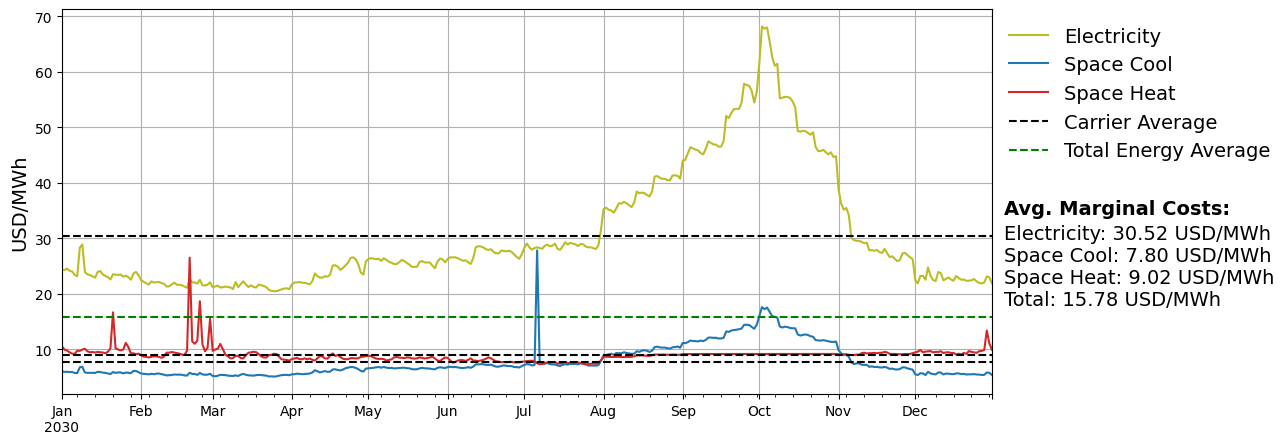

In [61]:
plot_marginal_costs(n, "res", average="both", save=Path(FIGURES, f"{REGION}_{SCENARIO}_res.png"))

(<Figure size 1200x500 with 1 Axes>, <Axes: ylabel='USD/MWh'>)

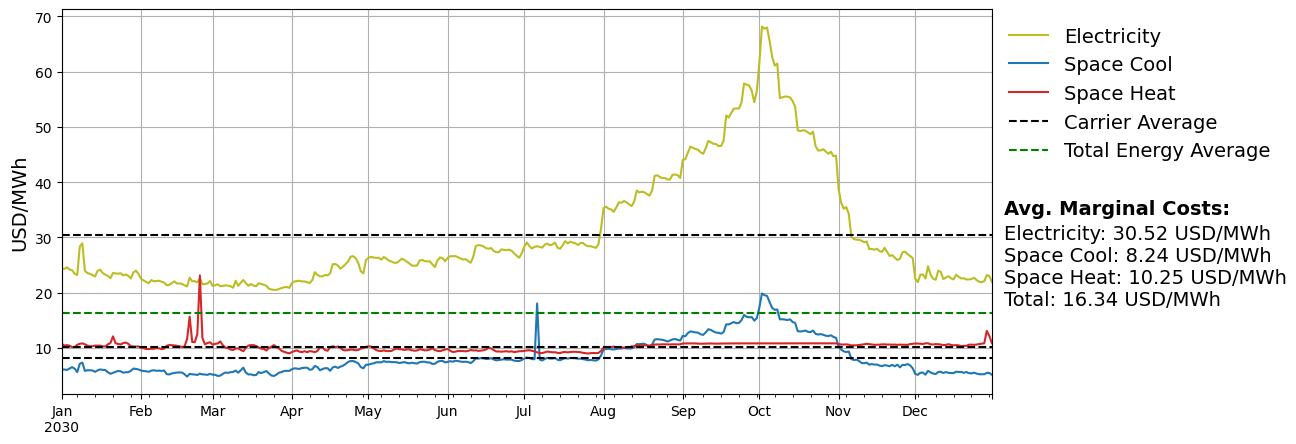

In [62]:
plot_marginal_costs(n, "com", average="both", save=Path(FIGURES, f"{REGION}_{SCENARIO}_com.png"))

(<Figure size 1200x500 with 1 Axes>, <Axes: ylabel='USD/MWh'>)

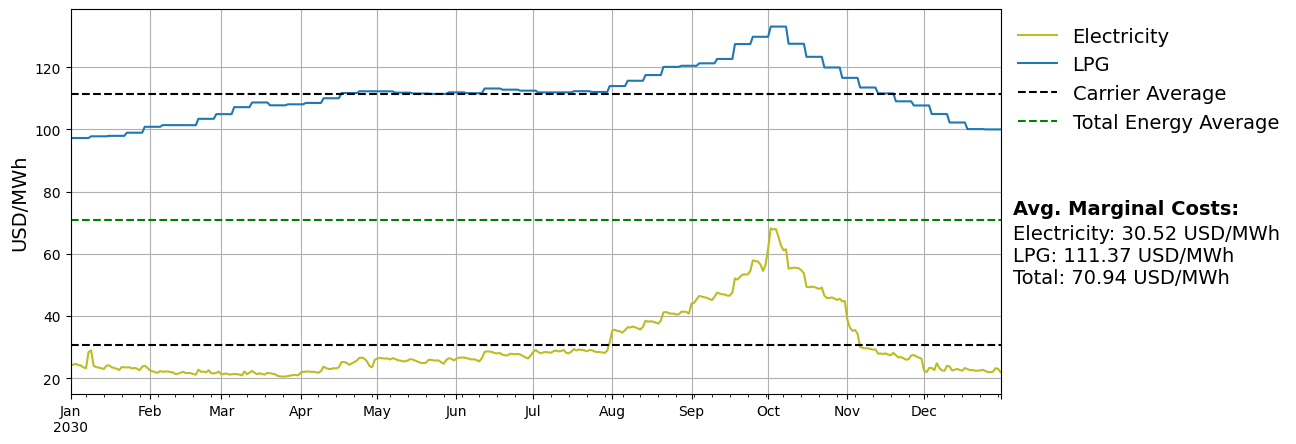

In [63]:
plot_marginal_costs(n, "trn", average="both", save=Path(FIGURES, f"{REGION}_{SCENARIO}_trn.png"))

(<Figure size 1200x500 with 1 Axes>, <Axes: ylabel='USD/MWh'>)

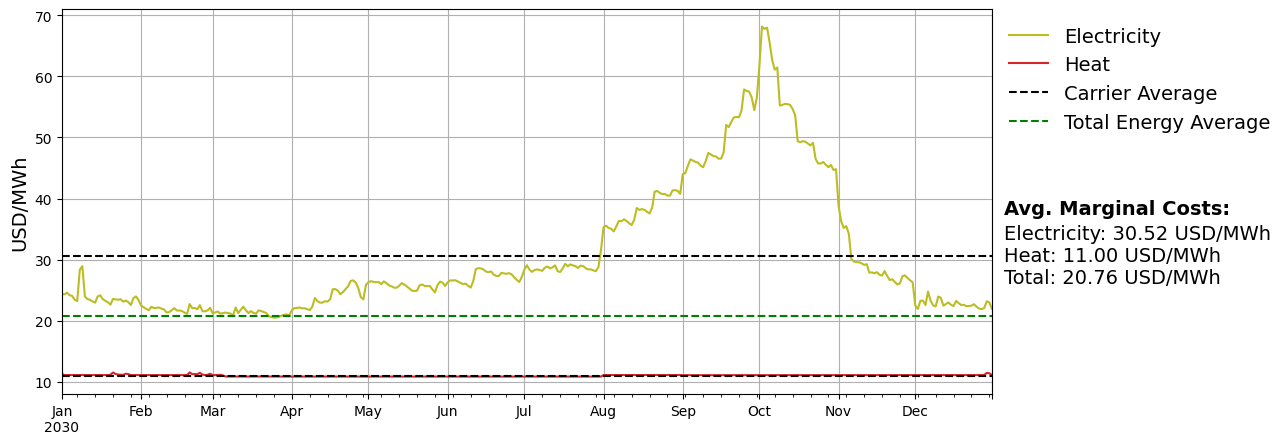

In [64]:
plot_marginal_costs(n, "ind", average="both", save=Path(FIGURES, f"{REGION}_{SCENARIO}_ind.png"))